# Land Cover Classification

## Imports

In [1]:
import cv2 as cv
import scipy.io as sio
import numpy as np
from random import seed
from random import randint
from matplotlib import pyplot as plt

## Read in the images

In [2]:
fe = cv.imread("fe.bmp")
le = cv.imread("le.bmp")
r = cv.imread("r.bmp")
g = cv.imread("g.bmp")
b = cv.imread("b.bmp")
nir = cv.imread("nir.bmp")

Using the OpenCV2 library, all of the image files are read into the notebook for use later in the project.

## Display the images

(<matplotlib.axes._subplots.AxesSubplot at 0x1dd31d4db08>,
 <matplotlib.image.AxesImage at 0x1dd31db8408>)

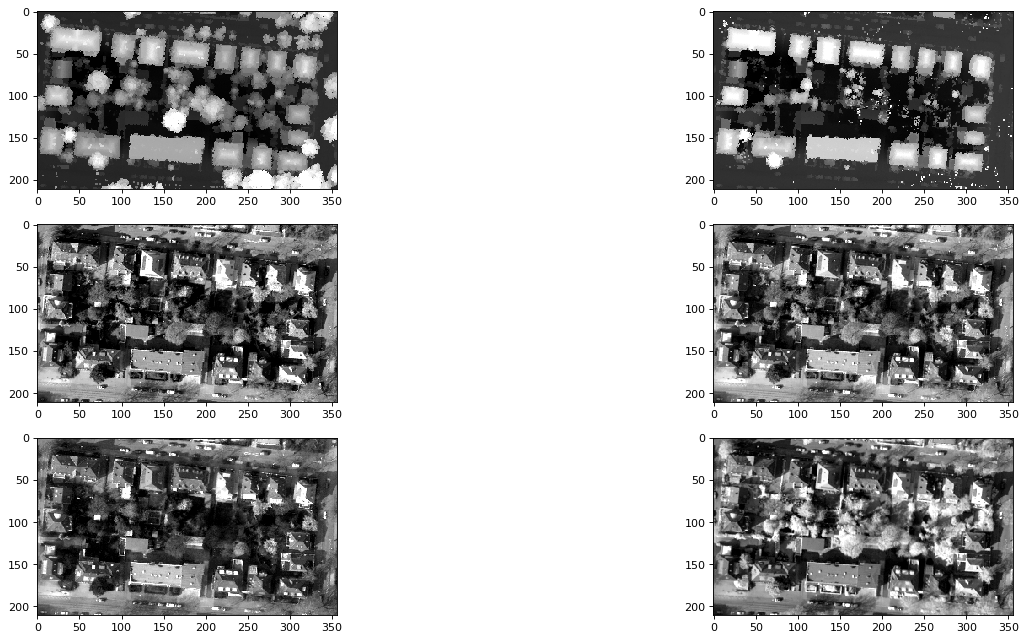

In [3]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(321), plt.imshow(fe, cmap = 'gray')
plt.subplot(322), plt.imshow(le, cmap = 'gray')
plt.subplot(323), plt.imshow(r, cmap = 'gray')
plt.subplot(324), plt.imshow(g, cmap = 'gray')
plt.subplot(325), plt.imshow(b, cmap = 'gray')
plt.subplot(326), plt.imshow(nir, cmap = 'gray')

Above are the 6 images for use in theis task. They are all of the same scene, but with differing levels of quality.

## Read in Ground Truth

In [4]:
matLab = sio.loadmat("ground_truth.mat")
ground_truth = matLab['labelled_ground_truth']

Since this is a Python notebook and the data to be used is a MATLAB file, the data must be read in and converted using the "scipy" library.

## Helper Functions

### Generate X and Y Coordinates

In [5]:
def genXY():
    # Get a random integer for X
    X = randint(0, 355)
    # Get a random integer for Y
    Y = randint(0, 210)
    # Return  Y,X since numpy indexes this way.
    return Y,X

The above function generates X and Y coordinate values based on the size of the numpy array. Since the ground_truth has specified dimensions, we can set the upper bounds for the generator accordingly

### Generate a Vector

In [6]:
def genVector(x,y):
    # Declare an empty list
    tmp = []
    # Append the pixel intensity for fe
    tmp.append(fe[x,y,1])
    # Append the pixel intensity for le
    tmp.append(le[x,y,1])
    # Append the pixel intensity for r
    tmp.append(r[x,y,1])
    # Append the pixel intensity for g
    tmp.append(g[x,y,1])
    # Append the pixel intensity for b
    tmp.append(b[x,y,1])
    # Append the pixel intensity for nir
    tmp.append(nir[x,y,1])
    # Return tmp
    return tmp

Based off of the passed (x,y) coordinate, generates a 6x1 vector. This is made by taking the pixel intensity from each of the 6 images loaded earlier.

### Generate all Training Samples

In [7]:
def genAllPoints():
    # Declare an empty list
    training_samples = []
    # Declare and set counters for each class in the ground_truth
    counter1 = 0;
    counter2 = 0;
    counter3 = 0;
    counter4 = 0;
    # While any counter is not equal to 5
    while (counter1 < 5 or counter2 < 5 or counter3 < 5 or counter4 < 5):
        # Generate a set of coordinates
        coords = genXY()
        # Get the class from the ground truth
        val = ground_truth[coords[0],coords[1]]
        # If the class is 1 and we haven't got 5 of that class yet
        if val == 1 and counter1 < 5:
            # Generate a vector and append it to training samples
            training_samples.append(genVector(coords[0], coords[1]))
            # Increment the counter for this class
            counter1+=1
        # If the class is 2 and we haven't got 5 of that class yet
        elif val == 2 and counter2 < 5:
            # Generate a vector and append it to training samples
            training_samples.append(genVector(coords[0], coords[1]))
            # Increment the counter for this class
            counter2+=1
        # If the class is 3 and we haven't got 5 of that class yet
        elif val == 3 and counter3 < 5:
            # Generate a vector and append it to training samples
            training_samples.append(genVector(coords[0], coords[1]))
            # Increment the counter for this class
            counter3+=1
        # If the class is 4 and we haven't got 5 of that class yet
        elif val == 4 and counter4 < 5:
            # Generate a vector and append it to training samples
            training_samples.append(genVector(coords[0], coords[1]))
            # Increment the counter for this class
            counter4+=1
    # Return the training samples
    return training_samples

This function generates the 20 training vectors. Given that there are 4 classes and we want 20 vectors, we can assume that we want 5 instances of each class in the training set. This gives us a even distribution of the classes in the training set.

## Generate the Training Samples

In [8]:
samples = genAllPoints()
samples = np.array(samples)

### Generate the Mean Vector

In [21]:
mean_vector = samples.mean(axis=0)
mean_vector

array([ 82.4 ,  81.45, 105.05, 112.35, 104.4 , 113.95])

### Generate the Covariance Matrix

In [28]:
cov_mat = np.cov(samples, rowvar=0)
cov_mat

(6, 6)

## Gaussian Model Creation

## Maximum Likelihood Classification

## Results and Evaluation